In [1]:
# # tf.keras.preprocessing.image_dataset_from_directory(
# #     directory, labels='inferred', label_mode='int', class_names=None,
# #     color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None,
# #     validation_split=None, subset=None, interpolation='bilinear', follow_links=False
# )

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 60

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "covid_data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7242 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
print(class_names)

['COVID', 'Normal']


In [7]:
len(dataset)

227

In [8]:
train_s = 0.8
train_s*len(dataset)

181.60000000000002

In [9]:
val_s = 0.1
val_s*len(dataset)

22.700000000000003

In [10]:
test_s = 0.1
test_s*len(dataset)

22.700000000000003

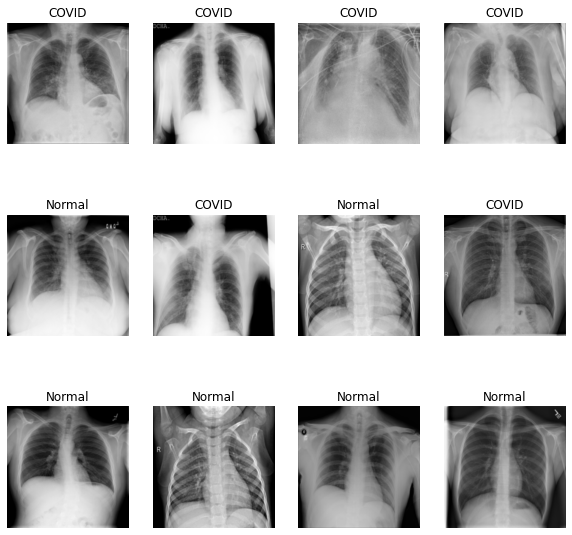

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
def split_dataset(ds, train_sp=0.8, val_sp=0.1, test_sp=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
         
    train_size = int(train_sp * ds_size)
    val_size = int(val_sp * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [13]:

train_ds, val_ds, test_ds = split_dataset(dataset)

In [14]:
len(train_ds)

181

In [15]:
len(val_ds)

22

In [16]:
len( test_ds)

24

In [17]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [23]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [24]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/60
181/181 [==============================] - 1146s 5s/step - loss: 0.6484 - accuracy: 0.6081 - val_loss: 0.4698 - val_accuracy: 0.7656
Epoch 2/60
181/181 [==============================] - 971s 4s/step - loss: 0.4912 - accuracy: 0.7570 - val_loss: 0.4830 - val_accuracy: 0.7841
Epoch 3/60
181/181 [==============================] - 1017s 4s/step - loss: 0.4455 - accuracy: 0.7865 - val_loss: 0.4247 - val_accuracy: 0.8253
Epoch 4/60
181/181 [==============================] - 877s 4s/step - loss: 0.4344 - accuracy: 0.7879 - val_loss: 0.4316 - val_accuracy: 0.8011
Epoch 5/60
181/181 [==============================] - 898s 4s/step - loss: 0.4263 - accuracy: 0.7925 - val_loss: 0.3781 - val_accuracy: 0.8196
Epoch 6/60
181/181 [==============================] - 1016s 4s/step - loss: 0.4202 - accuracy: 0.7962 - val_loss: 0.4248 - val_accuracy: 0.7884
Epoch 7/60
181/181 [==============================] - 950s 4s/step - loss: 0.4000 - accuracy: 0.8088 - val_loss: 0.4093 - val_accuracy: 0.8

Epoch 58/60
181/181 [==============================] - 907s 4s/step - loss: 0.1712 - accuracy: 0.9326 - val_loss: 0.1735 - val_accuracy: 0.9205
Epoch 59/60
181/181 [==============================] - 968s 4s/step - loss: 0.1599 - accuracy: 0.9373 - val_loss: 0.1588 - val_accuracy: 0.9318
Epoch 60/60
181/181 [==============================] - 1240s 4s/step - loss: 0.1862 - accuracy: 0.9217 - val_loss: 0.1727 - val_accuracy: 0.9304


In [25]:
scores = model.evaluate(test_ds)

24/24 [==============================] - 272s 2s/step - loss: 0.1610 - accuracy: 0.9401


first image to predict
actual label to predict: Normal
predicted label : Normal


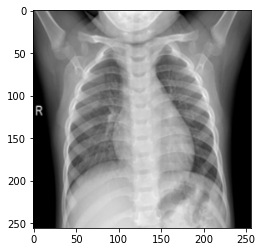

In [38]:
for images_batch, lables_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = lables_batch[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label to predict:', class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print('predicted label :', class_names[np.argmax(batch_prediction[0])])


In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

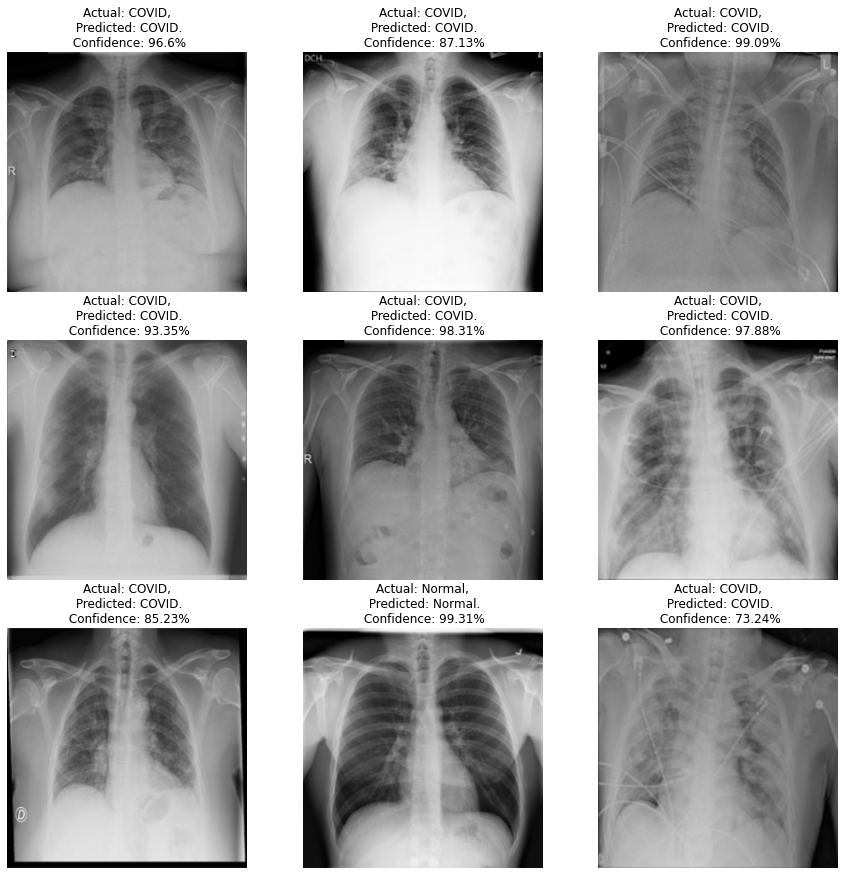

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [44]:
model_version = 3
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


In [45]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/5\assets
